# SHAP DeepExplainer

In [163]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [164]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
sns.set(font_scale=1.2)

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

In [165]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
# dfs.extract_df_info()
# df = dfs.df

# Creating train,val,test sets

## Removing outliers

In [4]:
# df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]

In [5]:
df_train = pd.read_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val = pd.read_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test = pd.read_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

topclasses = df_train['txt_label'].unique().tolist()

# plt.figure(figsize=(20,5))
# plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
# plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
# plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
# assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
# assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

# # df_train.label.value_counts()

# Creating Pytorch Datasets and Dataloaders

In [7]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    # A.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225], 
    #             p=1, 
    #             always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 128
batch_size_val = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [8]:
torch.backends.cudnn.benchmark = True

In [60]:
modelname = "vgg19"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)

In [62]:
optimizer = optim.Adam(model.parameters(), lr=.001)

model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)
model = model.to('cpu', dtype=torch.float)

In [63]:
labelticks = list({'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}.keys())
labeldict = {'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}
class_names = {str(v): [k,k] for k, v in labeldict.items()}

In [64]:
class_names

{'0': ['bl', 'bl'],
 '1': ['wswl', 'wswl'],
 '2': ['sp', 'sp'],
 '3': ['t', 't'],
 '4': ['sw', 'sw'],
 '5': ['k', 'k'],
 '6': ['m', 'm'],
 '7': ['c', 'c'],
 '8': ['v', 'v'],
 '9': ['wmv', 'wmv'],
 '10': ['wrl', 'wrl']}

In [65]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [67]:
import shap

batch = 1
for batch in test_dataloader:
    pass
batch = batch[0] #next(iter(test_dataloader))
batch

tensor([[[[171, 170, 170,  ..., 170, 171, 172],
          [169, 170, 170,  ..., 171, 171, 172],
          [169, 169, 170,  ..., 173, 173, 174],
          ...,
          [171, 173, 175,  ..., 174, 173, 174],
          [170, 171, 173,  ..., 175, 176, 176],
          [169, 170, 171,  ..., 174, 176, 176]],

         [[167, 166, 166,  ..., 166, 167, 168],
          [165, 166, 166,  ..., 167, 167, 168],
          [165, 165, 166,  ..., 169, 169, 170],
          ...,
          [167, 169, 171,  ..., 170, 169, 168],
          [166, 167, 169,  ..., 171, 172, 170],
          [165, 166, 167,  ..., 170, 171, 170]],

         [[176, 175, 175,  ..., 175, 175, 176],
          [174, 175, 175,  ..., 176, 176, 177],
          [174, 175, 176,  ..., 178, 177, 177],
          ...,
          [176, 178, 180,  ..., 179, 178, 177],
          [175, 176, 178,  ..., 180, 180, 178],
          [174, 175, 176,  ..., 179, 179, 177]]],


        [[[174, 172, 171,  ..., 173, 175, 175],
          [172, 172, 172,  ..., 173

In [68]:
batch = next(iter(test_dataloader))
X = batch[0].permute(0,2,3,1).numpy().astype('float')
X /= 255

X.shape

(128, 150, 150, 3)

In [69]:
to_explain = X[[2,3,4,5,127]]

In [74]:
e = shap.GradientExplainer((model, model.features[7]), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=11, nsamples=100)

In [75]:
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

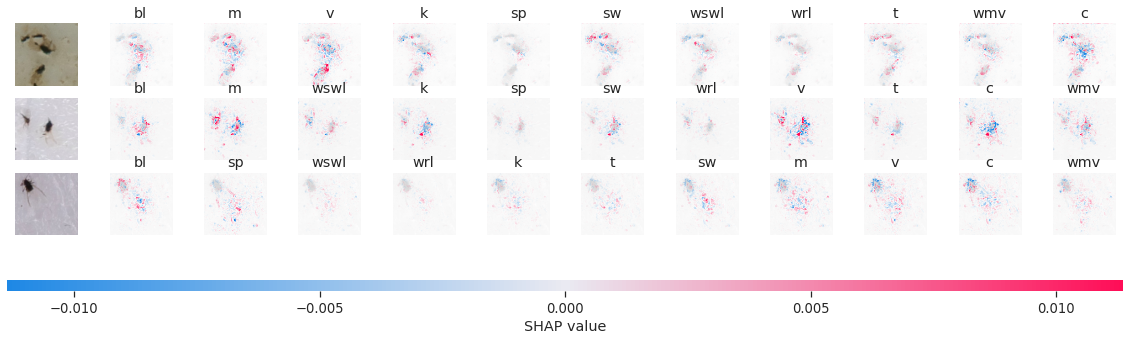

In [76]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)